## DisneyLand - Unsupervised NLP MVP

### Purpose:
#### The purpose of this analysis is to understand the ways in which theme park goes enjoy (or do not enjoy) disneyland. 

### Work Completed:
####  K-Means Clustering, Topic Modeling, Sentiment Analysis, Lgistic Regression on Review rating.

### Tools Used:

#### SK-Learn, Plotly, NLTK, Pandas, seaborn

In [1]:
import pandas as pd

df = pd.read_csv('DisneylandReviews.csv')
df.head()

Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong

## Step 1: Clean the Data.

Remove all digits and punctuation.

In [2]:
import nltk
import pandas as pd
import numpy as np
import re
import string

#remove capital letters and punctuaiton.
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['Review_Text_punc_edit'] = df['Review_Text'].map(alphanumeric).map(punc_lower)
df.head()

Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  \
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong   
1  Its been a while since d last time we visit HK...  Disneyland_HongKong   
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong   
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong   
4  the location is not in the city, took around 1...  Disneyland_HongKong   

                               Review_Text_punc_edit  
0  if you ve ever been to disneyland anywhere you...  
1  its been a while since d last time we visit hk...  
2  thanks god it wasn   t too hot or too humid wh...  
3  hk disneyland is a great compact park  unfortu...  
4  the location is not in the city  took around  ...

In [3]:
#import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [4]:
# Exclude stopwords with Python's list.
df['Review_Text_Clean'] = df['Review_Text_punc_edit'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [5]:
newdf = df[['Review_ID', 'Rating', 'Review_Text_Clean', 'Branch']]

In [6]:
newdf.head()

Review_ID  Rating                                  Review_Text_Clean  \
0  670772142       4  ever disneyland anywhere find disneyland hong ...   
1  670682799       4  since last time visit hk disneyland yet time s...   
2  670623270       4  thanks god hot humid visiting park otherwise w...   
3  670607911       4  hk disneyland great compact park unfortunately...   
4  670607296       4  location city took around hour kowlon kids lik...   

                Branch  
0  Disneyland_HongKong  
1  Disneyland_HongKong  
2  Disneyland_HongKong  
3  Disneyland_HongKong  
4  Disneyland_HongKong

In [7]:
import numpy as np

new_df = newdf.copy()
# Set 4/5 star reviews to positive, the rest to negative
new_df['sentiment'] = np.where(new_df['Rating'] >= 4, 'positive', 'negative')
# Include only the sentiment and reviews columns
data = new_df[['sentiment', 'Rating', 'Review_Text_Clean']]

In [8]:
data1 = data.sample(n=10000, random_state=0) #reduce size to 10K documents so that data runs faster.

## Step 2: Vectorize using TfidVectorizor

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [12]:
text = data1['Review_Text_Clean'].values
max_features = 1500

X = vectorize(text, max_features)

## Step 2: Prepare for kMeans Modeling. 
### Apply the Elbow Method using PCA decomposition (with components = .95 and components =2) in order to understand optimal k value.

#### PCA Decomposition with n_components = .95 and n_components = 2. Ultimately, we decided to use .95 since this produced better results.

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray()) #10k, 1472
X_reduced.shape

(10000, 1157)

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_reduced_test= pca.fit_transform(X.toarray()) #10k, 1472

(10000, 2)

#### Apply K-means to each of these decompositions

In [18]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [19]:
#does not run for large dataset. - ORIGINAL

from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 25)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

In [25]:
# - NEW

from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions_test = []
K_test = range(2, 35)
for k in K_test:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced_test)
    k_means.fit(X_reduced_test)
    distortions_test.append(sum(np.min(cdist(X_reduced_test, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

#### Evaluate the resulting Elbow graph. Choose K = 20

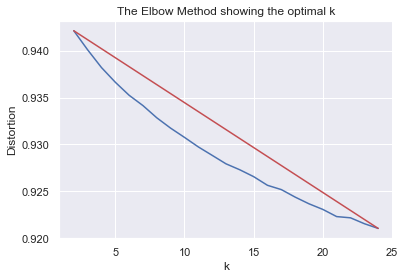

In [22]:
# took exceedingly long time to run ~ 30 min


from matplotlib import pyplot as plt
import seaborn as sns


X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

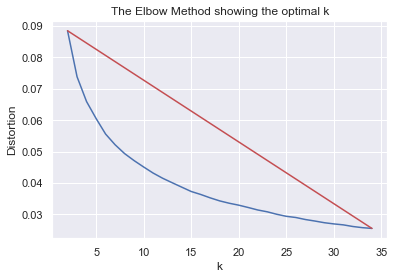

In [26]:
#very quick runtime ~ 1m


from matplotlib import pyplot as plt
import seaborn as sns


X_line = [K_test[0], K_test[-1]]
Y_line = [distortions_test[0], distortions_test[-1]]

# Plot the elbow
plt.plot(K_test, distortions_test, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [24]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
data1['y'] = y_pred

In [27]:
# use k = 20

k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred_test = kmeans.fit_predict(X_reduced_test)
data1['y_test'] = y_pred_test

In [28]:
data1.head()

sentiment  Rating                                  Review_Text_Clean  \
3281   negative       1  entered disneyland sad thing closed outdoor ri...   
19702  positive       5  people ask go disneyland disney world tell u s...   
35583  negative       3  quick writing bad reviews certainly disneyland...   
39775  positive       5  boyfriend visited disneyland paris celebrate s...   
31828  negative       3  day started disappointment raced space mountai...   

        y  y_test  
3281   12       1  
19702  19       5  
35583  19       2  
39775  19      17  
31828  19       3

In [29]:
X_reduced_test

array([[ 0.02031387, -0.00393132],
       [ 0.08303429, -0.03092587],
       [ 0.11070753,  0.11976258],
       ...,
       [-0.1524819 , -0.01782186],
       [ 0.11103598, -0.11352972],
       [-0.00520876,  0.09104013]])

#### -------------------------------------------------------------
#### look at clustering methods - TSNE performs the best.
#### -------------------------------------------------------------

#### TSNE -

In [34]:
from sklearn.manifold import TSNE 

tsne = TSNE(verbose=1, perplexity=50, n_iter=1000)
X_embedded = tsne.fit_transform(X.toarray())

/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 9.740s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.234768
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.221123
[t-SNE] KL divergence after 1000 iterations: 3.713231


#### Truncated SVD - 

In [32]:
from sklearn.decomposition import TruncatedSVD
lsa_model_test = TruncatedSVD(n_components=2, algorithm= 'randomized', n_iter=100, random_state=42)

lsa_top_test=lsa_model_test.fit_transform(X)

#### PCA - 

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_reduced_test= pca.fit_transform(X.toarray()) #10k, 1472
X_reduced_test.shape

(10000, 2)

#### -------------------------------
#### Evaluate resulting visuals
#### -------------------------------

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


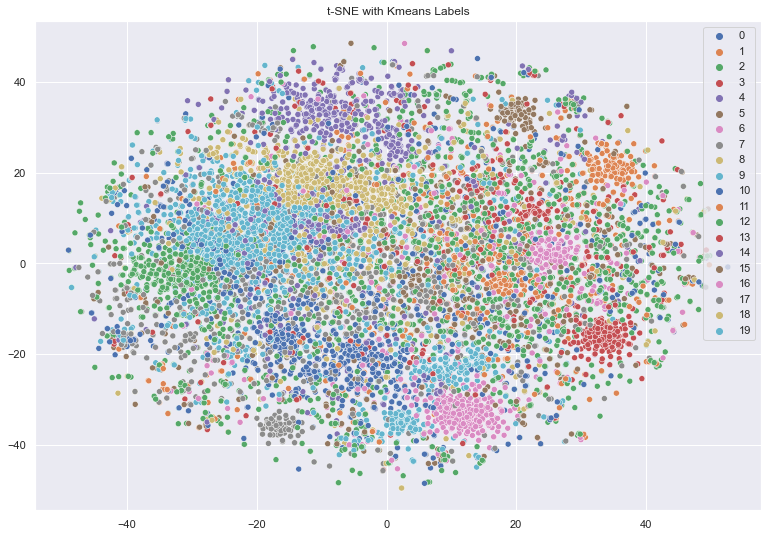

In [38]:

# -------------
# Using TSNE
# -------------


%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette= 'deep')
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("improved_cluster_tsne.png")
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


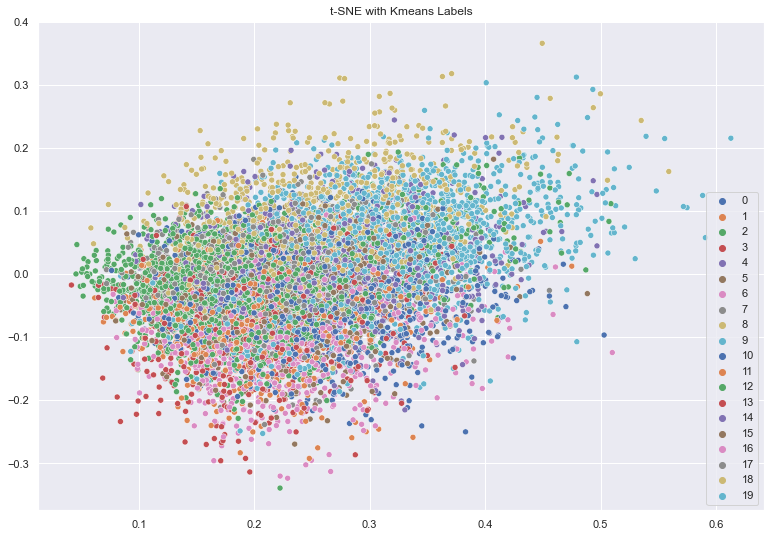

In [43]:

# -------------
# Using LSA SVD
# -------------


%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(lsa_top_test[:,0], lsa_top_test[:,1], hue=y_pred, legend='full', palette= 'deep')
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("improved_cluster_tsne.png")
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


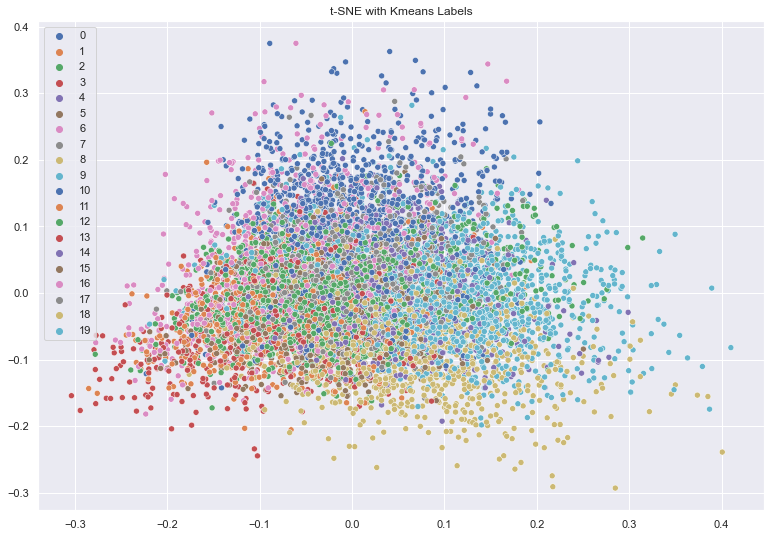

In [45]:

# -------------
# Using PCA
# -------------


%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_reduced_test[:,0], X_reduced_test[:,1], hue=y_pred, legend='full', palette= 'deep')
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("improved_cluster_tsne.png")
plt.show()

#### TSNE visual without color.

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


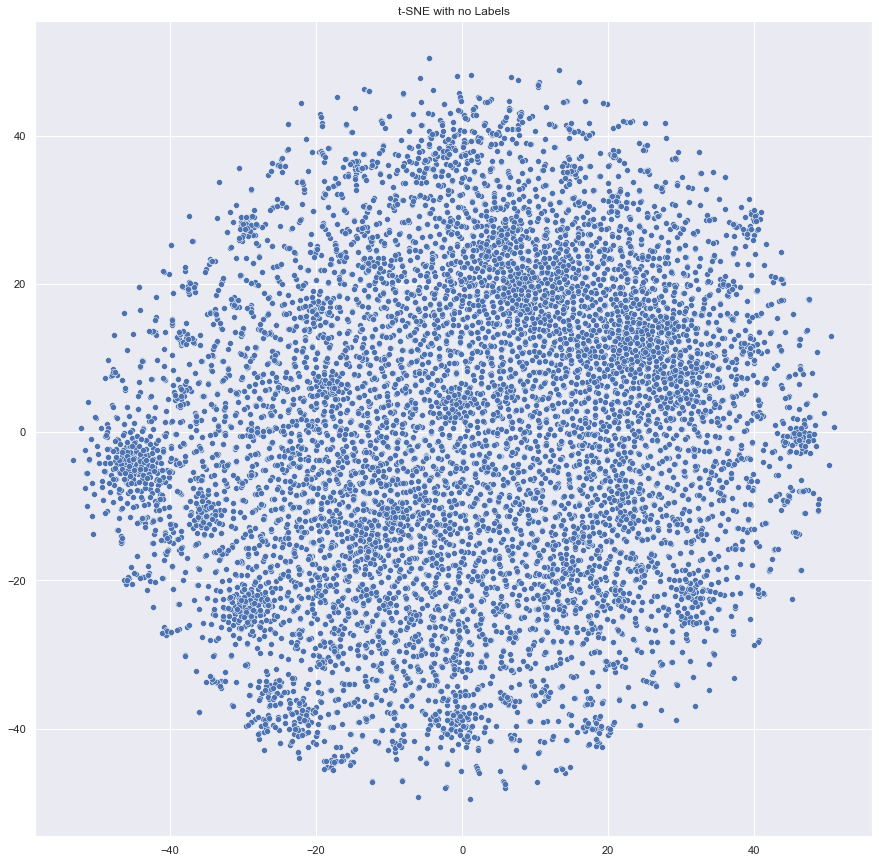

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
# plt.savefig("t-sne_covid19.png")
plt.show()

#### TSNE visual for specific topics

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


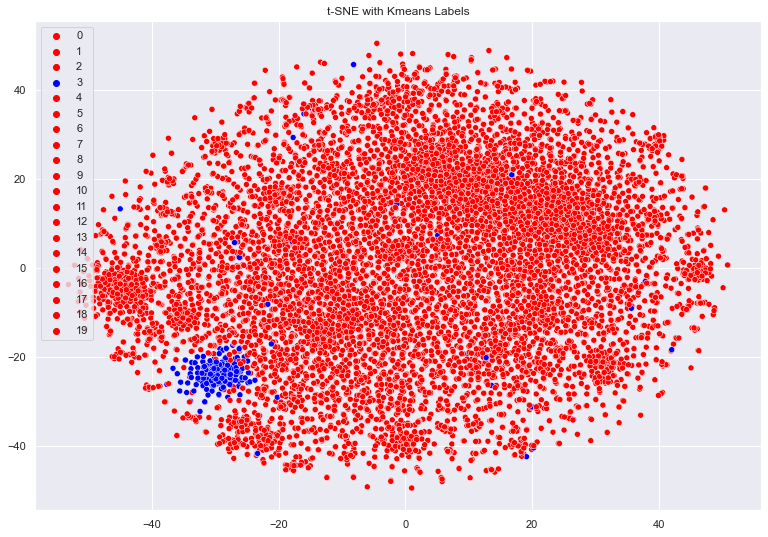

In [39]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import colorcet as cc
import numpy as np
import matplotlib.pyplot as plt



# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
#palette = sns.hls_palette(20, l=.4, s=.9)
palette = sns.color_palette(cc.glasbey, n_colors=20)
test = ['red', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']
# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue= y_pred, legend='full', palette= test)

# colors = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #red is 0, blue is 1
# ax.scatter(X_embedded[:,0], X_embedded[:,1], c=colors, marker="o", cmap="bwr_r")

#sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue= data1['y'], legend='full', palette= palette)


plt.title('t-SNE with Kmeans Labels')
# plt.savefig("improved_cluster_tsne.png")
plt.show()



In [40]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast


import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

## Step 3: Topic Modeling

In [68]:
#import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

#### Initialize TfidVectorizor with 1.5K max features and transform data.

In [69]:
#stop-words
stop_words=set(nltk.corpus.stopwords.words('english'))
vect =TfidfVectorizer(stop_words=stop_words,max_features=1500) #changed 1000 to 2000

In [70]:
vect_text=vect.fit_transform(data1['Review_Text_Clean'])

<10000x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 433847 stored elements in Compressed Sparse Row format>

In [71]:
idf=vect.idf_

In [72]:
dd=dict(zip(vect.get_feature_names(), idf))
l=sorted(dd, key=(dd).get)

#### Create LSA Topic Model

In [73]:
from sklearn.decomposition import TruncatedSVD
lsa_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=10, random_state=42)

lsa_top=lsa_model.fit_transform(vect_text)

In [77]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
      print("Topic ",i," : ",topic*100)
  

Document 0 :
Topic  0  :  19.857172443118554
Topic  1  :  4.96996268318278
Topic  2  :  1.5970568206858209
Topic  3  :  4.91270302937209
Topic  4  :  2.5072359288056014
Topic  5  :  -8.379586813986517
Topic  6  :  2.1781828714594513
Topic  7  :  0.9920875485390193
Topic  8  :  -9.876579797019359
Topic  9  :  -0.19822104334233015
Topic  10  :  3.1871265569387783
Topic  11  :  0.007380302269190153
Topic  12  :  -5.8622481242270865
Topic  13  :  -4.411029699802039
Topic  14  :  1.7054819152295848
Topic  15  :  -0.7085460022771243
Topic  16  :  -1.990082059565167
Topic  17  :  -5.134488410245183
Topic  18  :  -3.7041628373957405
Topic  19  :  -3.1295121568709297


#### Get feature names for each topic.

In [76]:
# most important words for each topic
vocab = vect.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:5]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
park disney rides disneyland day 

Topic 1: 
fast get pass ride wait 

Topic 2: 
disney park parks paris world 

Topic 3: 
disneyland california ride love always 

Topic 4: 
kong hong day disneyland fireworks 

Topic 5: 
great rides fun disney mountain 

Topic 6: 
ride mountain loved parade show 

Topic 7: 
place rides kids fun mountain 

Topic 8: 
disney place pass fast fireworks 

Topic 9: 
kids disney fun go day 

Topic 10: 
day place great one happiest 

Topic 11: 
disney great kong hong time 

Topic 12: 
kids park loved fast pass 

Topic 13: 
long rides lines wait day 

Topic 14: 
fast pass rides staff amazing 

Topic 15: 
visit time good year old 

Topic 16: 
love day go park back 

Topic 17: 
year old park fun kong 

Topic 18: 
visit kids fun one staff 

Topic 19: 
time go really would back 



In [78]:
data1['Review_Text_Clean'].iloc[0]

'entered disneyland sad thing closed outdoor rides pm well informed us bought tickets went hongkong go disneyland tickets cost us pesos hkd already know gonna close based forecast yet still let us buy tickets stayed inside hour took pictures rode hyperspace mountain took bad experience want money didnt care lose'

#### Observe WordCloud doe each topic (data in streamlit)

In [45]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):
  imp_words_topic=""
  comp=lsa_model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

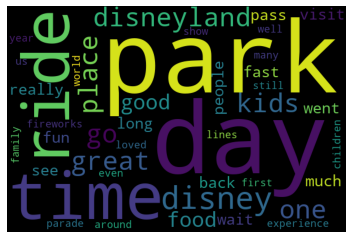

In [46]:
draw_word_cloud(0) # Word cloud for topic 0

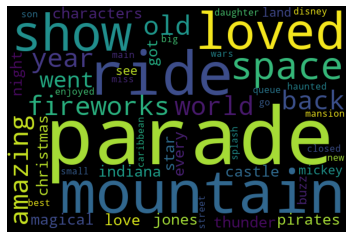

In [47]:
draw_word_cloud(6) # Word cloud for topic 6

## -----------------------------------------------------------------------------------------------------------
## ------------------------------------- Additional Analysis ----------------------------------------------
## -----------------------------------------------------------------------------------------------------------

## Logistic Regression model -

In [9]:
# Split the data into X and y data sets
X = data.Review_Text_Clean
y = data.sentiment

In [10]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aa  aaa  aaaages  aaaargh  aaahhh  aaahs  aaarrr  aaat  aack  aagh  ...  \
0   0    0        0        0       0      0       0     0     0     0  ...   
1   0    0        0        0       0      0       0     0     0     0  ...   
2   0    0        0        0       0      0       0     0     0     0  ...   
3   0    0        0        0       0      0       0     0     0     0  ...   
4   0    0        0        0       0      0       0     0     0     0  ...   

   zoned  zones  zoo  zoom  zooming  zooms  zootopia  zorbs  zorg  zurg  
0      0      0    0     0        0      0         0      0     0     0  
1      0      0    0     0        0      0         0      0     0     0  
2      0      0    0     0        0      0         0      0     0     0  
3      0      0    0     0        0      0         0      0     0     0  
4      0      0    0     0        0      0         0      0     0     0  

[5 rows x 33084 columns]

In [12]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
# try tfidf vecotrizer

#ngram_range=1
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aa  aa introductory  aa rides  aaa  aaa arrived  aaa believe  aaa card  \
0   0                0         0    0            0            0         0   
1   0                0         0    0            0            0         0   
2   0                0         0    0            0            0         0   
3   0                0         0    0            0            0         0   
4   0                0         0    0            0            0         0   

   aaa cheaper  aaa costco  aaa day  ...  zorg laser  zurg  zurg blasters  \
0            0           0        0  ...           0     0              0   
1            0           0        0  ...           0     0              0   
2            0           0        0  ...           0     0              0   
3            0           0        0  ...           0     0              0   
4            0           0        0  ...           0     0              0   

   zurg catch  zurg fun  zurg infernal  zurg minions  zurg ride  zurg times  \
0           0         0              0             0          0           0   
1           0         0              0             0          0           0   
2           0         0              0             0          0           0   
3           0         0              0             0          0           0   
4           0         0              0             0          0           0   

   zurg upper  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 711874 columns]

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [14]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [15]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [16]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

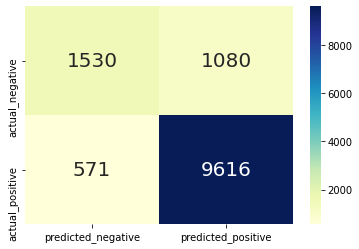

In [17]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

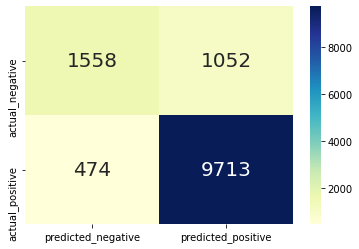

In [18]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [19]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

LogReg1  LogReg2
Accuracy     0.871    0.881
Precision    0.899    0.902
Recall       0.944    0.953
F1 Score     0.921    0.927

## Create N-Gram -

In [20]:
import collections
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py

#Needed Definitions


def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stop]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


#### Create ngram for all reviews

In [21]:
freq_dict = collections.defaultdict(int)
for sent in data['Review_Text_Clean']:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# from plotly import tools
# import plotly.offline as py
fig = tools.make_subplots(rows=1, cols=1)
fig.append_trace(trace1, 1, 1)

fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="Trigram - All Reviews")
py.iplot(fig, filename='word-plots')

/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



#### NGram - only positive reviews

In [22]:
freq_dict = collections.defaultdict(int)
for sent in data['Review_Text_Clean'][data['sentiment']== 'positive']:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

fig = tools.make_subplots(rows=1, cols=1)
fig.append_trace(trace1, 1, 1)

fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots - Positive")
py.iplot(fig, filename='word-plots')

/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



#### NGram - only negative reviews

In [23]:
freq_dict = collections.defaultdict(int)
for sent in data['Review_Text_Clean'][data['sentiment']== 'negative']:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

fig = tools.make_subplots(rows=1, cols=1)
fig.append_trace(trace1, 1, 1)

fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots - Negative")
py.iplot(fig, filename='word-plots')

## Sentiment analysis + Wordcloud. 

In [21]:
from wordcloud import WordCloud, STOPWORDS

In [22]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stop,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))

In [23]:
# import matplotlib.pyplot as plt #Visulization
    
plot_wordcloud(data['Review_Text_Clean'], title="Word Cloud of review")

In [32]:
# WORDCLOUD NOT WORKING FOR ME 

from textblob import TextBlob
from wordcloud import WordCloud #wordcloud is not working
# Create a function to get the subjectivity
def getSubjectivity(text):
       return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
       return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
data['Subjectivity'] = data['Review_Text_Clean'].apply(getSubjectivity)
data['Polarity'] = data['Review_Text_Clean'].apply(getPolarity)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [38]:
from textblob import TextBlob
from wordcloud import WordCloud #wordcloud is not working
# Create a function to get the subjectivity
def getSubjectivity(text):
       return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
       return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
data['Subjectivity'] = data['Review_Text_Clean'].apply(getSubjectivity)
data['Polarity'] = data['Review_Text_Clean'].apply(getPolarity)



def getAnalysis(score):
    if score<0:
        return 'Negative'
    elif score ==0:
        return 'Neutral'
    else:
        return 'Positive'
    
#savedTweets['Analysis'] = savedTweets['Polarity'].apply(getAnalysis)
data1['Analysis']=data1['Polarity'].apply(getAnalysis)

In [39]:
data.head()

sentiment  Rating                                  Review_Text_Clean  \
0  positive       4  ever disneyland anywhere find disneyland hong ...   
1  positive       4  since last time visit hk disneyland yet time s...   
2  positive       4  thanks god hot humid visiting park otherwise w...   
3  positive       4  hk disneyland great compact park unfortunately...   
4  positive       4  location city took around hour kowlon kids lik...   

   Subjectivity  Polarity  
0      0.531481  0.226852  
1      0.438235  0.160784  
2      0.435065  0.171861  
3      0.505556  0.222222  
4      0.437500  0.266667

In [41]:
data['Analysis']=data['Polarity'].apply(getAnalysis)

In [43]:
data.head()

sentiment  Rating                                  Review_Text_Clean  \
0  positive       4  ever disneyland anywhere find disneyland hong ...   
1  positive       4  since last time visit hk disneyland yet time s...   
2  positive       4  thanks god hot humid visiting park otherwise w...   
3  positive       4  hk disneyland great compact park unfortunately...   
4  positive       4  location city took around hour kowlon kids lik...   

   Subjectivity  Polarity  analysis  Analysis  
0      0.531481  0.226852  Positive  Positive  
1      0.438235  0.160784  Positive  Positive  
2      0.435065  0.171861  Positive  Positive  
3      0.505556  0.222222  Positive  Positive  
4      0.437500  0.266667  Positive  Positive

In [1]:
#analysis

fig = plt.figure(figsize=(7,5))
color = ['green','grey','red']
data['Analysis'].value_counts().plot(kind='bar',color = color)
plt.title('Value count')
plt.ylabel('Count')
plt.xlabel('Polarity')
plt.grid(False)
plt.show()

In [5]:
# #sentiment

fig = plt.figure(figsize=(7,5))
color = ['green','grey','red']
data['sentiment'].value_counts().plot(kind='bar',color = color)
plt.title('Value count')
plt.ylabel('Count')
plt.xlabel('Polarity')
plt.grid(False)
plt.show()

In [35]:
#create a function for wordcloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')


def create_wordcloud(text):    
    allWords = ' '.join([tweets for tweets in text])
    wordCloud = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130).generate(allWords)
    plt.figure(figsize=(20,10))
    plt.imshow(wordCloud)
    plt.axis('off')
    plt.show()

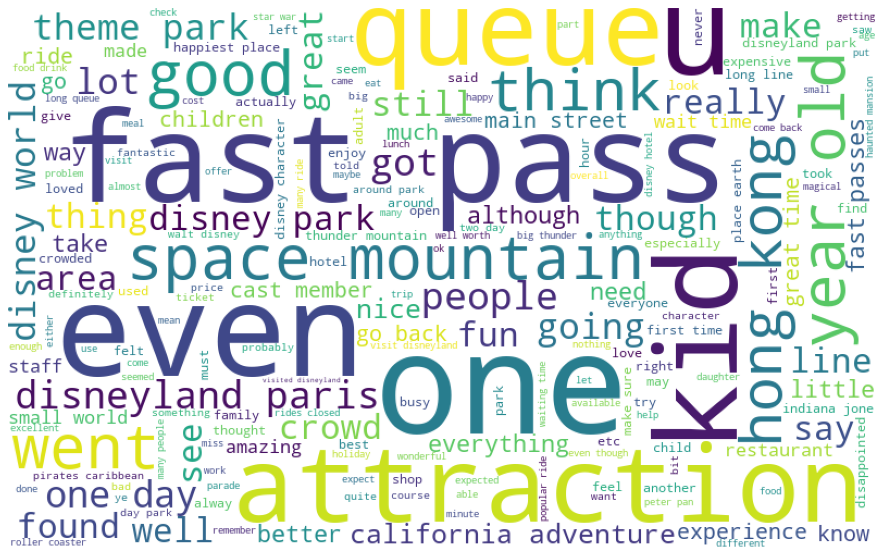

In [36]:
create_wordcloud(data['Review_Text_Clean'])

In [27]:
data.describe() #~43K documents

Rating
count  42656.000000
mean       4.217695
std        1.063371
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000

In [29]:
agg = data['Review_Text_Clean'].str.split(expand=True).stack().value_counts().head(100)

In [34]:
agg.head(20) # top words are park, disney (disneyland), rides, time and day.

park          45346
disney        37139
rides         35004
disneyland    33568
time          29899
day           28909
get           23091
go            20338
one           19547
ride          18065
great         16635
food          14818
would         14809
kids          14400
place         13588
good          13360
really        12437
like          11995
visit         11922
see           11807
dtype: int64

In [46]:
#review over time by year